

## Гипотезы:

- В нулевой гипотезой будем считать H0: нормальное распределение;
- в качестве альтернативной считаем H1: другое распределение от нормального.

## 1. ИЗУЧЕНИЕ ДАННЫХ

In [ ]:
import pandas as pd
import numpy as np
from numpy.random import randn
from matplotlib import pyplot
from scipy.stats import shapiro
from scipy.stats import boxcox

%matplotlib inline

In [ ]:
# Открываем и помещаем данные в переменную 'ecom_data_students':

ecom_data_students = pd.read_csv('ecom_data_students.csv')

In [ ]:
# Рассмотрим наши данные:
    
ecom_data_students.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,GroupType
0,571664,22302,COFFEE MUG PEARS DESIGN,72,10/18/2011 12:59,2.100,17090.0,United Kingdom,control
1,573585,23086,ZINC STAR T-LIGHT HOLDER,1,10/31/2011 14:41,2.952,NaN,United Kingdom,test
2,556905,84596F,SMALL MARSHMALLOWS PINK BOWL,1,6/15/2011 13:05,0.420,16904.0,United Kingdom,control
3,561710,21066,VINTAGE RED MUG,1,7/29/2011 11:45,1.500,13827.0,United Kingdom,test
4,560078,22570,FELTCRAFT CUSHION RABBIT,4,7/14/2011 16:12,4.500,16040.0,United Kingdom,test


In [ ]:
ecom_data_students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    500000 non-null  object 
 1   StockCode    500000 non-null  object 
 2   Description  498662 non-null  object 
 3   Quantity     500000 non-null  int64  
 4   InvoiceDate  500000 non-null  object 
 5   UnitPrice    500000 non-null  float64
 6   CustomerID   375361 non-null  float64
 7   Country      500000 non-null  object 
 8   GroupType    500000 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 34.3+ MB


## 2. ИЗУЧЕНИЕ КЛЮЧЕВОЙ МЕТРИКИ

<AxesSubplot:>

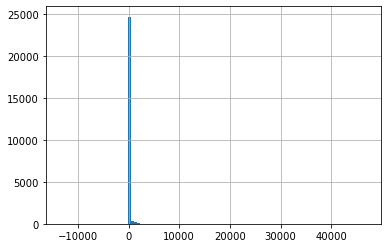

In [ ]:
# Так как нам надо будет посчитать и сравнивать между собой средний чек, давайте посмотрим на его распределение:

ecom_data_students.groupby('InvoiceNo').UnitPrice.sum().hist(bins = 100)

In [ ]:
# Удаляем данные с отрицательными значениями UnitPrice - возвраты по товарам:

ecom_data_students = ecom_data_students[ecom_data_students.UnitPrice > 0]

<AxesSubplot:>

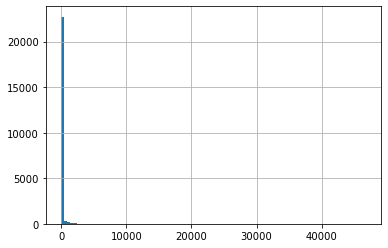

In [ ]:
# И посмотрим на распределение ещё раз:

ecom_data_students.groupby('InvoiceNo').UnitPrice.sum().hist(bins = 100)

In [ ]:
# Смотрим на уникальное количество пользователей:

ecom_data_students.CustomerID.nunique()

4370

In [ ]:
# Смотрим на первоначальное значение среднего чека:

print(round(ecom_data_students.groupby('InvoiceNo').UnitPrice.sum().mean(), 2))

114.53


## 3. ТЕСТИРОВАНИЕ ПОДХОДА С ЛОГАРИФМИРОВАНИЕМ

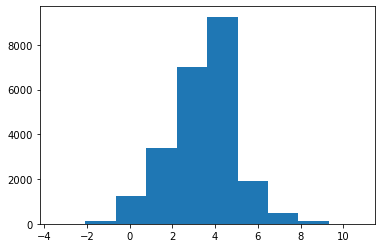

In [ ]:
# Посмотрим, как выглядит трансформированное распределение:

from matplotlib import pyplot

log_mean_bills = ecom_data_students.groupby('InvoiceNo').UnitPrice.sum().apply(lambda x: np.log(x)).values.tolist()

pyplot.hist(log_mean_bills)
pyplot.show()

In [ ]:
# Проверим результат с помощью критерия Шапиро-Уилка:

stat, p_value = shapiro(log_mean_bills)
print(f'stat = {stat}, p-value = {p_value}')

stat = 0.9867745041847229, p-value = 2.7567744688662126e-41


C:\Users\Max\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


p-value сильно ниже 0.05, поэтому логарифмирование не помогло трансформировать данные, чтобы применить к ним параметрические критерии.

## 4. ТЕСТИРОВАНИЕ ПРЕОБРАЗОВАНИЯ БОКСА-КОКСА

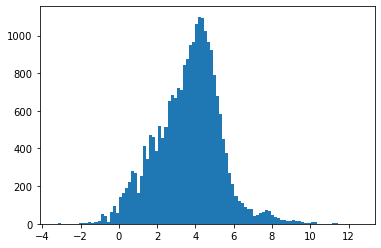

In [ ]:
# Применим более мощный способ с трансформацией Бокса-Кокса:

boxcox_mean_bills, fitted_lambda = boxcox(ecom_data_students.groupby('InvoiceNo').UnitPrice.sum().values.tolist())

pyplot.hist(boxcox_mean_bills, bins = 100)
pyplot.show()

In [ ]:
# Также, проведём тест на нормальность с помощью критерия Шапиро-Уилка:

stat, p_value = shapiro(boxcox_mean_bills)
print(f'stat = {stat}, p-value = {p_value}')

stat = 0.9874508380889893, p-value = 1.887619096368745e-40


Как и в случае с логарифмированием, p-value значительно ниже уровня значимости 5%.

## 5. ТЕСТИРОВАНИЕ ПОДХОДА БУТСТРЭП-СЭМПЛИРОВАНИЯ

100%|██████████| 10000/10000 [00:12<00:00, 798.15it/s]


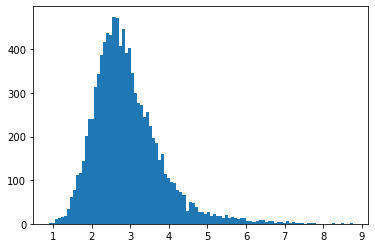

In [ ]:
# Теперь, проверяем гипотезу о разности среднего чека для контрольной и тестовой группы через бутстрэп-сэмплирование.
# Генерируем 300 случайных подвыборок, с помощью сэмплируемых итераций в 10000 раз.

from tqdm import tqdm

np.random.seed(1)
all_values_test = ecom_data_students[ecom_data_students.GroupType == 'test'].groupby('InvoiceNo').UnitPrice.sum().values.tolist()
all_values_control = ecom_data_students[ecom_data_students.GroupType == 'control'].groupby('InvoiceNo').UnitPrice.sum().values.tolist()

sample_mean_ratio = []

for i in tqdm(range(10000)):
    sample_test = np.random.choice(all_values_test, size = 300)
    sample_control = np.random.choice(all_values_control, size = 300)
    sample_mean_ratio.append(sample_test.mean() / sample_control.mean())
    
pyplot.hist(sample_mean_ratio, bins = 100)
pyplot.show()

In [ ]:
# Смотрим на значения среднего чек в контрольной и тестируемой группе:

sample_mean_control = sample_control.mean()
print(sample_mean_control)
sample_mean_test = sample_test.mean()
print(sample_mean_test)

51.679233333333336
162.2796000000001


In [ ]:
print(f'Control 95 percentile: {np.percentile(sample_mean_control, 95)}')
print(f'Test 5 percentile: {np.percentile(sample_mean_test, 5)}')

Control 95 percentile: 51.679233333333336
Test 5 percentile: 162.2796000000001


95 персентиль у контрольного распределения меньше, чем 5 персентиль у тестового распределения - это говорит о том, что разность между ними статистически значимая на уровне значимости 0.95. Таким образом, мы отвергаем нулевую гипотезу о том, что распределение нормальное и поэтому считаем наш эксперимент тестируемой гипотезы успешным.

In [ ]:
# Считаем матожидание отношения среднего чека тестовой группы относительно контрольной:

print(round(sum(sample_mean_ratio) / len(sample_mean_ratio), 2))

2.92


In [ ]:
# Смотрим значения 95% доверительного интервала:

print(np.percentile(sample_mean_ratio, 2.5), np.percentile(sample_mean_ratio, 97.5))

1.6007426580117279 5.184796070320843


In [ ]:
# Межквартильный размах - разницу между крайними значениями у 95% доверительного интервала:

print(round(np.percentile(sample_mean_ratio, 97.5) - np.percentile(sample_mean_ratio, 2.5), 2))

3.58


### Вывод:

В результате нашего эксперимента, распределение вероятностни прироста по среднему чеку находиться в диапазоне от 1.601 до 5.185 раз, с вероятностью 95%.